In [19]:
# %pip install munch loguru scipy "dask[diagnostics]"

In [1]:
%load_ext autoreload
%autoreload 2

import cryogrid_pytools as cgt
import pandas as pd

# Reading CryoGrid output

Currently only support for `read_OUT_regridded_FCI2`

In [14]:
fname = '/Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/runs/strat/strat_578067_20020101.mat'
cgt.read_OUT_regridded_FCI2_file(fname, deepest_point=-5)

<xarray.Dataset> Size: 4MB
Dimensions:       (time: 1461, depth: 151)
Coordinates:
  * time          (time) datetime64[ns] 12kB 2001-01-01 ... 2002-01-01
  * depth         (depth) float64 1kB 2.5 2.45 2.4 2.35 ... -4.9 -4.95 -5.0
Data variables:
    T             (time, depth) float32 882kB dask.array<chunksize=(1461, 151), meta=np.ndarray>
    water         (time, depth) float32 882kB dask.array<chunksize=(1461, 151), meta=np.ndarray>
    ice           (time, depth) float32 882kB dask.array<chunksize=(1461, 151), meta=np.ndarray>
    class_number  (time, depth) float32 882kB dask.array<chunksize=(1461, 151), meta=np.ndarray>
    FCI           (time, depth) float32 882kB dask.array<chunksize=(1461, 151), meta=np.ndarray>
    elevation     (depth) float64 1kB dask.array<chunksize=(151,), meta=np.ndarray>
Attributes:
    filename:  /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/runs/strat/st...

In [15]:
fname = "/Users/luke/SDSC/CryoGrid/ITCH-ML/spatial_simulations/Tronfjell_spatial3/Tronfjell_spatial3_*_2015*.mat"
out = cgt.read_OUT_regridded_FCI2_clusters(fname)
out

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished


<xarray.Dataset> Size: 459MB
Dimensions:       (gridcell: 120, time: 1461, depth: 131)
Coordinates:
  * gridcell      (gridcell) int64 960B 56 57 237 347 ... 26404 26408 26504
  * time          (time) datetime64[ns] 12kB 2014-09-01 ... 2015-09-01
  * depth         (depth) float64 1kB 1.5 1.45 1.4 1.35 ... -4.9 -4.95 -5.0
Data variables:
    T             (gridcell, depth, time) float32 92MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    water         (gridcell, depth, time) float32 92MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    ice           (gridcell, depth, time) float32 92MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    class_number  (gridcell, depth, time) float32 92MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    FCI           (gridcell, depth, time) float32 92MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    elevation     (gridcell, depth) float64 126kB dask.array<chunksize=(1, 131), meta=np.ndarray>

# Reading struct files from MATLAB

Note that `run_info.mat` cannot be read as it contains special classes that are not supported by `scipy.io.loadmat`.  

To save parts of `run_info`, use the following code in MATLAB:


```matlab
run_info_spatial = run_info.SPATIAL.STATVAR
save "run_info_spatial.mat" run_info_spatial
```

In [16]:
fname = '/Users/luke/SDSC/CryoGrid/ITCH-ML/spatial_simulations/run_spatial_statvar.mat'
spatial = cgt.read_mat_struct_as_dataset(fname, index=['Y', 'X'])
spatial

<xarray.Dataset> Size: 1MB
Dimensions:         (Y: 178, X: 149)
Coordinates:
  * Y               (Y) int32 712B 6898675 6898700 6898725 ... 6903075 6903100
  * X               (X) int32 596B 274107 274132 274157 ... 277757 277782 277807
Data variables:
    latitude        (Y, X) float64 212kB 62.15 62.15 62.15 ... 62.19 62.19 62.19
    longitude       (Y, X) float64 212kB 10.66 10.66 10.66 ... 10.73 10.73 10.73
    key             (Y, X) uint16 53kB 1 179 357 535 ... 25988 26166 26344 26522
    mask            (Y, X) uint8 27kB 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    altitude        (Y, X) float64 212kB 944.8 952.9 959.9 ... 848.4 843.0 838.0
    slope_angle     (Y, X) float64 212kB 23.31 21.27 17.86 ... 13.59 13.29 12.32
    aspect          (Y, X) float64 212kB 312.4 314.1 317.5 ... 118.9 122.9 122.0
    skyview_factor  (Y, X) float64 212kB 0.9592 0.9659 0.9759 ... 0.9866 0.9885
    horizon_bins    (Y, X) uint8 27kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    horizon_angles  (Y, X) uint8 27kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

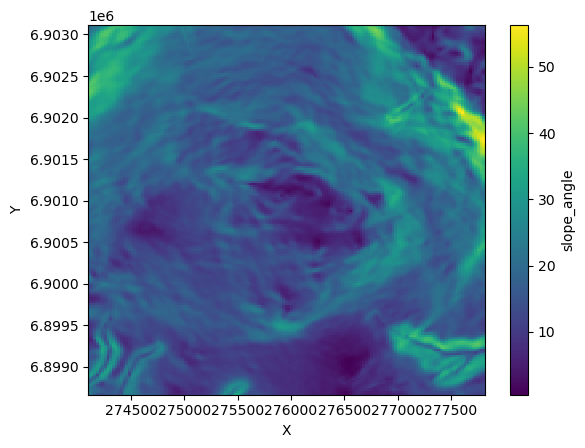

In [17]:
spatial.slope_angle.plot()

# Reading Excel config files

This is experimental. Could be used to run checks on files, and configurations for the model.

In [18]:
fname = '/Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/runs/strat/strat.xlsx'
config = cgt.CryoGridConfigExcel(fname, checks=False)

forcing_path = config.get_forcing_path()
print(forcing_path)

2024-10-25 17:32:07.758 | INFO     | cryogrid_pytools.excel_config:_get_root_path:45 - Found root path: /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov


2024-10-25 17:32:07.948 | SUCCESS  | cryogrid_pytools.excel_config:__init__:24 - Loaded CryoGrid Excel configuration file: /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/runs/strat/strat.xlsx
2024-10-25 17:32:07.975 | INFO     | cryogrid_pytools.excel_config:__init__:37 - Start and end times: 2000-01-01 - 2002-12-31


/Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/forcing/cryogrid-pamir_abramov-era5-1970_2020.mat


In [19]:
fname = "/Users/luke/SDSC/CryoGrid/ITCH-ML/point_simulations/Tronfjell_bias_correct_sediment_snow3x_19550901.mat"
fname = "/Users/luke/SDSC/CryoGrid/ITCH-ML/spatial_simulations/Tronfjell_spatial3/Tronfjell_spatial3_10151_19440901.mat"

In [23]:
ds = cgt.read_OUT_regridded_FCI2_file(fname)
ds

<xarray.Dataset> Size: 4MB
Dimensions:       (time: 1465, level: 131)
Coordinates:
  * time          (time) datetime64[ns] 12kB 1943-09-01 ... 1944-09-01
Dimensions without coordinates: level
Data variables:
    T             (time, level) float32 768kB dask.array<chunksize=(1465, 131), meta=np.ndarray>
    water         (time, level) float32 768kB dask.array<chunksize=(1465, 131), meta=np.ndarray>
    ice           (time, level) float32 768kB dask.array<chunksize=(1465, 131), meta=np.ndarray>
    class_number  (time, level) float32 768kB dask.array<chunksize=(1465, 131), meta=np.ndarray>
    FCI           (time, level) float32 768kB dask.array<chunksize=(1465, 131), meta=np.ndarray>
    elevation     (level) float64 1kB dask.array<chunksize=(131,), meta=np.ndarray>
Attributes:
    filename:  /Users/luke/SDSC/CryoGrid/ITCH-ML/spatial_simulations/Tronfjel...

In [22]:
cgt.read_OUT_regridded_FCI2_file(fname, deepest_point=-5)

<xarray.Dataset> Size: 4MB
Dimensions:       (time: 1465, depth: 131)
Coordinates:
  * time          (time) datetime64[ns] 12kB 1943-09-01 ... 1944-09-01
  * depth         (depth) float64 1kB 1.5 1.45 1.4 1.35 ... -4.9 -4.95 -5.0
Data variables:
    T             (time, depth) float32 768kB dask.array<chunksize=(1465, 131), meta=np.ndarray>
    water         (time, depth) float32 768kB dask.array<chunksize=(1465, 131), meta=np.ndarray>
    ice           (time, depth) float32 768kB dask.array<chunksize=(1465, 131), meta=np.ndarray>
    class_number  (time, depth) float32 768kB dask.array<chunksize=(1465, 131), meta=np.ndarray>
    FCI           (time, depth) float32 768kB dask.array<chunksize=(1465, 131), meta=np.ndarray>
    elevation     (depth) float64 1kB dask.array<chunksize=(131,), meta=np.ndarray>
Attributes:
    filename:  /Users/luke/SDSC/CryoGrid/ITCH-ML/spatial_simulations/Tronfjel...